# MCMF Text Classification

## Load Packages

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

# model-building
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, hamming_loss

## Load Data

I did my initial data cleaning of the raw dataset in R and saved it as a CSV file. I did the following to clean the data:
* Selected out unnecessary variables
* Grouped the original 22 categories to 4 broader categories
* Got rid of duplicate observations
* Took out observations with multiple categories
* Took out observations with Spanish descriptinos

The code for the initial data cleaning can be found in [`cleaning/model_cleaning.R`](https://github.com/emmayu18/MCMF-project/blob/main/cleaning/model_cleaning.R)

In [13]:
# cleaned data from cleaning/model_clean.R
dat = pd.read_csv("../data/wrangle/text_classify.csv")
dat = dat.drop(["index", "Unnamed: 0"], axis = 1)
dat

,program_name,description,category
0,STEM Academy,<p><strong>The UIC – CHANCE STEM Academy Progr...,Professional Skill Building
1,CHANCE - Digital Scholars Program,<p>This <strong>5-Week Virtual Summer Program<...,Professional Skill Building
2,Future Leaders in Business,<p>The <strong>UIC Future Leaders in Business ...,Professional Skill Building
3,Divas Code Virtual Meetup,<p>Our weekly virtual office hours are an to g...,Professional Skill Building
4,Divas Office Hours,<p>Our weekly virtual office hours are an to g...,Professional Skill Building
...,...,...,...
20221,Spring Break STEM Camp,<p>Project Exploration creates transformative ...,Academics
20222,The Art Institute of Chicago Ryan Learning Cen...,The Art Exchange in the Ryan Learning Center (...,Leisure and Arts
20223,ILA Match Apprenticeship,<p>Are you between the ages of 12-14 and have ...,Leisure and Arts
20224,Student WEB CORPS 2023,"<p>Student WEB CORPS is a 6-week program, from...",Professional Skill Building


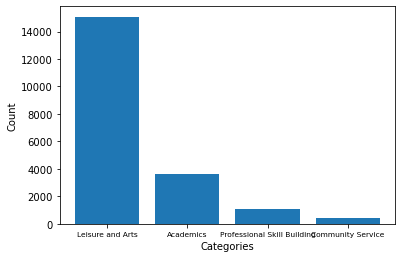

In [149]:
x = dat["category"].value_counts()

plt.bar(x.index, x)
plt.xlabel('Categories')
plt.tick_params(axis='x', labelsize=7.5)
plt.ylabel('Count')
plt.show()

There is a big imbalance in the outcome variable so I will be stratifying the test/train data by category and using stratified K-fold during grid search. I will also be using the macro averaging method for my performance metrics.

## Text Pre-Processing

Text pre-processing steps:
* Turned all characters to lowercase
* Stripped strings of leading and trailing spaces
* Removed HTML tags, HTML entities, and URL links
* Removed punctuation, numbers, and special characters
* Removed all words with less than 3 characters
* Converted all spaces to single-space
* Removed stop words
* Stemmed words
* Removed stop words again after stemming
* Removed 30 most frequently used words

In [14]:
# text conversion
def clean_text(text):
    # lower strings
    text = text.lower()
    # strip
    text = text.strip()
    # remove html tags
    text = re.sub("<.*?>", " ", text)
    # remove html entities
    text = re.sub("&.*?;", " ", text)
    # remove URL links
    text = re.sub("https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", " ", text)
    text = re.sub("www(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
    # remove punctuation, numbers, and special characters
    text = re.sub("[^a-zA-Z\\s]", " ", text)
    # remove all words with nchar <= 2
    text = re.sub(r'\b\w{1,2}\b', " ", text)
    # remove words that start with "zoom"
    text = re.sub("zoom\w+", " ", text)
    # remove words that start with "zoom"
    text = re.sub("accessibility\w+", " ", text)
    # all spaces to singlespace 
    text = re.sub('\s+', ' ', text)  
    return text

# stop word removal
custom_stopwords = stopwords.words('english')
custom_stopwords.extend(["event", "chicago", "please", "program", "camp", "tbd", "tba","internship", "illinois", 
                         "zoom","january", "february", "march", "april", "may", "june", "july", "august", 
                         "september", "october", "november", "december", "monday", "tuesday", "wednesday", "thursday",
                         "friday", "saturday", "sunday", "sun", "mon", "tue", "wed", "thu", "fri", "sat"])
custom_stopwords = [re.sub("[^a-zA-Z\\s]", "", text) for text in custom_stopwords]

def remove_stopword(string):
    a = [i for i in string.split() if i not in custom_stopwords]
    return ' '.join(a)

# stemming
ps = PorterStemmer()

def stemmer(string):
    tokens = word_tokenize(string)
    a = [ps.stem(word) for word in tokens]
    return " ".join(a)

# final function
def finalpreprocess(string):
    return remove_stopword(stemmer(remove_stopword(clean_text(string))))
dat['clean_text'] = dat['description'].apply(lambda x: finalpreprocess(x))

In [15]:
# remove frequent words
cnt = Counter()
for text in dat["clean_text"].values:
    for word in text.split():
        cnt[word] += 1

freq_words = set([w for (w, wc) in cnt.most_common(30)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in freq_words])
dat['clean_text'] = dat['clean_text'].apply(lambda x: remove_freqwords(x))

dat.head()

,program_name,description,category,clean_text
0,STEM Academy,<p><strong>The UIC – CHANCE STEM Academy Progr...,Professional Skill Building,uic chanc stem academi five week academ intens...
1,CHANCE - Digital Scholars Program,<p>This <strong>5-Week Virtual Summer Program<...,Professional Skill Building,week virtual summer afford high school sophomo...
2,Future Leaders in Business,<p>The <strong>UIC Future Leaders in Business ...,Professional Skill Building,uic futur leader busi free summer partnership ...
3,Divas Code Virtual Meetup,<p>Our weekly virtual office hours are an to g...,Professional Skill Building,weekli virtual offic hour get feedback support...
4,Divas Office Hours,<p>Our weekly virtual office hours are an to g...,Professional Skill Building,weekli virtual offic hour get feedback support...


## Split Data

In [16]:
# split predictor and outcome variables
y = dat["category"]
X = dat["clean_text"]

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify = y, 
                                                    shuffle=True,
                                                    random_state = 42)

## Convert to TF-IDF Matrix

In [17]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Models and Grid Search

### Logistic Regression

In [4]:
lr = LogisticRegression()
lr_grid = {"C": [10, 1.0, 0.1, 0.01]}

lr_grid_search = GridSearchCV(estimator = lr, 
                              param_grid = lr_grid, 
                              scoring = "accuracy", 
                              cv = StratifiedKFold())
lr_grid_search = lr_grid_search.fit(X_train_tfidf, y_train)
lr.set_params(**lr_grid_search.best_params_)

print("Best parameters: ", lr_grid_search.best_params_)
print("Best score: ", lr_grid_search.best_score_)

Best parameters:  {'C': 10}
Best score:  0.869283065512979


### Multinomal Naive-Bayes

In [5]:
nb = MultinomialNB()
nb_grid = {"alpha": [0.0001, 0.001, 0.1, 1, 10, 100]}

nb_grid_search = GridSearchCV(estimator = nb, 
                              param_grid = nb_grid, 
                              scoring = "accuracy", 
                              cv = StratifiedKFold())
nb_grid_search = nb_grid_search.fit(X_train_tfidf, y_train)
nb.set_params(**nb_grid_search.best_params_)

print("Best parameters: ", nb_grid_search.best_params_)
print("Best score: ", nb_grid_search.best_score_)

Best parameters:  {'alpha': 0.001}
Best score:  0.8299752781211372


### Random Forest

In [6]:
rf = RandomForestClassifier()
rf_grid = {'n_estimators': [100, 150, 200],
           'max_depth': [200, None]}

rf_grid_search = GridSearchCV(estimator = rf, 
                              param_grid = rf_grid, 
                              scoring = "accuracy", 
                              cv = StratifiedKFold())
rf_grid_search = rf_grid_search.fit(X_train_tfidf, y_train)
rf.set_params(**rf_grid_search.best_params_)

print("Best parameters: ", rf_grid_search.best_params_)
print("Best score: ", rf_grid_search.best_score_)

Best parameters:  {'max_depth': None, 'n_estimators': 200}
Best score:  0.8526576019777503


### SVM

In [7]:
svm = LinearSVC()
svm_grid = {"C": [0.01, 0.1, 1, 10]}

svm_grid_search = GridSearchCV(estimator = svm, 
                               param_grid = svm_grid, 
                               scoring = "accuracy", 
                               cv = StratifiedKFold())
svm_grid_search = svm_grid_search.fit(X_train_tfidf, y_train)
svm.set_params(**svm_grid_search.best_params_)

print("Best parameters: ", svm_grid_search.best_params_)
print("Best score: ", svm_grid_search.best_score_)

Best parameters:  {'C': 1}
Best score:  0.872991347342398


### K-Nearest Neighbors

In [8]:
knn = KNeighborsClassifier()
knn_grid = {"n_neighbors": np.arange(1, 10, 2), 
            "weights": ["uniform", "distance"]}

knn_grid_search = GridSearchCV(estimator = knn, 
                               param_grid = knn_grid, 
                               scoring = "accuracy", 
                               cv = StratifiedKFold())
knn_grid_search = knn_grid_search.fit(X_train_tfidf, y_train)
knn.set_params(**knn_grid_search.best_params_)

print("Best parameters: ", knn_grid_search.best_params_)
print("Best score: ", knn_grid_search.best_score_)

Best parameters:  {'n_neighbors': 1, 'weights': 'uniform'}
Best score:  0.8121755253399259


### Stacked Model

In [30]:
estimators = [('lr', lr),
              ('nb', nb),
              ('rf', rf),
              ('svm', svm),
              ('knn', knn)
             ]

stack = StackingClassifier(estimators = estimators,
                           final_estimator = LogisticRegression())

In [37]:
print("Cross validation score:", np.mean(cross_val_score(stack, X_train_tfidf, y_train, cv=5)))

Cross validation score: 0.8750927099999999


## Train and Test Model

The model with the highest average cross validated training score was the stacked model. The following dataframe contains the performance metrics from predicting the testing data with the training data fitted model.

In [171]:
stack_fitted = stack.fit(X_train_tfidf, y_train)
y_pred_stack = stack_fitted.predict(X_test_tfidf)
y_pred_prob = stack_fitted.predict_proba(X_test_tfidf)

In [9]:
pd.DataFrame({"Metric": ["Accuracy", 
                         "F1-score", 
                         "Precision", 
                         "Recall", 
                         "ROC AUC", 
                         "Hamming Loss"],
              "Value": [accuracy_score(y_test, y_pred_stack), 
                        f1_score(y_test, y_pred_stack, average = "macro"), 
                        precision_score(y_test, y_pred_stack, average = 'macro'), 
                        recall_score(y_test, y_pred_stack, average = 'macro'), 
                        roc_auc_score(y_test, y_pred_prob, multi_class = 'ovo'), 
                        hamming_loss(y_test, y_pred_stack)]})

,Metric,Value
0,Accuracy,0.884577
1,F1-score,0.732632
2,Precision,0.810972
3,Recall,0.680385
4,ROC AUC,0.944863
5,Hamming Loss,0.115423


All of the performance metrics are in the acceptable to good range, indicating that the model is sufficient at categorizing the MCMF programs through their descriptions. Recall is the lowest, most likely due to the imbalance in the data.

## Test Updated Data (2024)

The following data is an updated MCMF dataset downloaded in August 2024 (original data used to train was downloaded in April 2023). I used it as an extra testing set to check the performance of my model.

In [10]:
new_dat = pd.read_csv("../data/wrangle/new_data_clean.csv").drop("Unnamed: 0", axis = 1)
new_dat['clean_text'] = new_dat['description'].apply(lambda x: finalpreprocess(x))

X_new = new_dat["clean_text"]
X_new_tfidf = tfidf_vectorizer.transform(X_new)

In [11]:
pred = stack_fitted.predict(X_new_tfidf)
pred_prob = stack_fitted.predict_proba(X_new_tfidf)
true = new_dat["category"]

pd.DataFrame({"Metric": ["Accuracy", 
                         "F1-score", 
                         "Precision", 
                         "Recall", 
                         "ROC AUC", 
                         "Hamming Loss"],
              "Value": [accuracy_score(true, pred), 
                        f1_score(true, pred, average = "macro"), 
                        precision_score(true, pred, average = 'macro'), 
                        recall_score(true, pred, average = 'macro'), 
                        roc_auc_score(true, pred_prob, multi_class = 'ovo'), 
                        hamming_loss(true, pred)]})

,Metric,Value
0,Accuracy,0.847931
1,F1-score,0.638887
2,Precision,0.738829
3,Recall,0.595067
4,ROC AUC,0.900640
5,Hamming Loss,0.152069


The performance is slightly worse than what we saw with the testing set but it is pretty similar. In this case, the f1-score and recall are in slightly concerning range, indicating that the model is most likely conservative in its prediction.

## Predict Unclassified Data


### Multi-category observations from original data

The following dataset is a subset of the original data that was labeled with multiple categories that was removed from the training data. I want to predict the categories of these programs using my model to see if it matches at least one of the true categories.

In [12]:
unclass_dat = pd.read_csv("../data/wrangle/unclassified_text.csv")
unclass_dat = unclass_dat.rename(columns = {"Unnamed: 0": "index"})
unclass_dat['clean_text'] = unclass_dat['description'].apply(lambda x: finalpreprocess(x))

X_unclass = unclass_dat["clean_text"]
X_unclass_tfidf = tfidf_vectorizer.transform(X_unclass)

In [177]:
pred = stack_fitted.predict(X_unclass_tfidf)
results = pd.concat([unclass_dat[["program_name", 
                                  "academics_dum", 
                                  "leisure_arts_dum", 
                                  "community_service_dum", 
                                  "professional_skill_dum"]], 
                     pd.Series(pred)], axis = 1)
results = results.rename(columns = {"academics_dum": "Academics", 
                                    "leisure_arts_dum": "Leisure and Arts", 
                                    "community_service_dum": "Community Service", 
                                    "professional_skill_dum": "Professional Skill Building",
                                    0: "pred"})
results

,program_name,Academics,Leisure and Arts,Community Service,Professional Skill Building,pred
0,Hack the Pandemic,1,0,1,0,Leisure and Arts
1,Virtual Workshops,1,0,0,1,Professional Skill Building
2,Art & Science Workshop Series: Intro to Art!,1,1,0,0,Leisure and Arts
3,The Science of Art Virtual Workshop,1,1,0,0,Academics
4,The Art of Science virtual workshop,1,1,0,0,Academics
...,...,...,...,...,...,...
1081,Coach for Success - UIC Student Life Visit,1,1,0,0,Academics
1082,Coach for Success Program,1,0,0,1,Academics
1083,Code For Good Hackathon,1,0,0,1,Professional Skill Building
1084,Global Partners Project,0,0,1,1,Professional Skill Building


In [178]:
def correct(row):
    pred = row["pred"]
    if row[pred] == 1:
        return True
    else:
        return False

compare = results.apply(func = correct, axis = 1)
print("Number of correctly labeled observations:", np.sum(compare))
print("Proportion of correctly labeled observations:", np.sum(compare) / len(compare))

Number of correctly labeled observations: 994
Proportion of correctly labeled observations: 0.9152854511970534


### Handmade Sample Data

I created some sample descriptions of two programs for each of the four categories to see if my model could accurately predict the categories.

In [179]:
description1 = "Come learn Python coding at the Chicago Public Library! We will be going over the basics of computer programming along with a fun activity of making a tic-tac-toe game using code."
description2 = "Origami, painting, paper mache, ceramics, drawing, we have it all! Join us for a weekend of hands-on crafts and acitivities. We are located in Rogers Park, Illinois. Make sure to bring your parent's signatures."
description3 = "Do you need volunteering hours? Cleveland Clinic is looking for students to give back to their community through many different opportunities. Whether you're interested in patient interaction or looking for a more behind the scenes work, we have all sorts of ways you can help! Contact us if you're interested."
description4 = "We are offering tutoring services to middle school and high school students who are looking for extra afterschool help. We have college student tutors who have experience in teaching math, english, science, and history. The cost is covered by the Chicago Charity Foundation! Contact us at 123-456-7890 or find us at www.tutoring.com."
description5 = "Are you interested in pursuing law as a career? Come speak to current law students, lawyers, district attorneys, and judges at the Chicago Pre-Law panel. You'll have many opportunities for one-on-one conversations with professionals in the law field where you can ask any questions and network."
description6 = "Baseball camp for middle schoolers. August 13-16, 2024 at Chicago Public High School. Contact Coach Johnson for more information and any questions."
description7 = "It's the yuletide season! This is a chance for you to give back to your community by volunteering at the Rosewood Soup Kitchen. Spread the holiday spirit this weekend with us. We offer volunteering hours."
description8 = "Chicago Science Foundation is hosting a 4-day summer camp where we will be exploring everything to do with space! If you're interested in learning about spaceships, astrophysics, aliens, and the outer space, this is the camp for you. We will also have engineers from NASA come speak about their experience studying astronomy and aerospace engineering."
"Professional Skill Building"
sample_dat = pd.DataFrame({"description": [description1, description2, description3, description4, description5, description6, description7, description8],
                           "category": ["Professional Skill Building", "Leisure and Arts", "Community Service", "Academics", "Professional Skill Building", "Leisure and Arts", "Community Service", "Academics"]})
sample_dat

,description,category
0,Come learn Python coding at the Chicago Public...,Professional Skill Building
1,"Origami, painting, paper mache, ceramics, draw...",Leisure and Arts
2,Do you need volunteering hours? Cleveland Clin...,Community Service
3,We are offering tutoring services to middle sc...,Academics
4,Are you interested in pursuing law as a career...,Professional Skill Building
5,Baseball camp for middle schoolers. August 13-...,Leisure and Arts
6,It's the yuletide season! This is a chance for...,Community Service
7,Chicago Science Foundation is hosting a 4-day ...,Academics


In [180]:
sample_dat['clean_text'] = sample_dat['description'].apply(lambda x: finalpreprocess(x))
X_sample = sample_dat["clean_text"]
X_sample_tfidf = tfidf_vectorizer.transform(X_sample)

pred = stack_fitted.predict(X_sample_tfidf)
true = sample_dat['category']

sample_results = pd.concat([sample_dat['category'], pd.Series(pred)], axis = 1)
sample_results = sample_results.rename(columns = {"category": "true", 0: "predicted"})
sample_results

,true,predicted
0,Professional Skill Building,Professional Skill Building
1,Leisure and Arts,Leisure and Arts
2,Community Service,Leisure and Arts
3,Academics,Academics
4,Professional Skill Building,Professional Skill Building
5,Leisure and Arts,Leisure and Arts
6,Community Service,Leisure and Arts
7,Academics,Academics


It looks like the model is good at predicting the categories on completely new data but has trouble classifying Community Service opportunities. This could be because of the imbalance in the training dataset. Community Service was the smallest category in the training data while Leisure and Arts was the largest.

## Next Steps

In order to improve performance, I could implement text augmentation (synonym replacement, random insertion/deletion, text paraphrasing, etc.). I could also experiment with a hybrid of random over/undersampling and class weighting. I have tried both techniques separately but saw a decrease in performance, but I think an appropriate combination of those methods could possibly improve performance. Increasing the number of TF-IDF features have shown to increase performance and if I had the computing power, that is another strategy I would experiment with. However, I would have to be careful not to overfit the training data.